In [44]:
# imports
%matplotlib inline

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist,distplot
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from spark_stratifier import StratifiedCrossValidator
from pyspark.ml.feature import Imputer
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from IPython.display import display
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [2]:
# Schema of the data in pyspark
schema=StructType([
    StructField("id", FloatType(), True),
    StructField("target", FloatType(), True),
    StructField("ps_ind_01", FloatType(), True),
    StructField("ps_ind_02_cat", FloatType(), True),
    StructField("ps_ind_03", FloatType(), True),
    StructField("ps_ind_04_cat", FloatType(), True),
    StructField("ps_ind_05_cat", FloatType(), True),
    StructField("ps_ind_06_bin", FloatType(), True),
    StructField("ps_ind_07_bin", FloatType(), True),
    StructField("ps_ind_08_bin", FloatType(), True),
    StructField("ps_ind_09_bin", FloatType(), True),
    StructField("ps_ind_10_bin", FloatType(), True),
    StructField("ps_ind_11_bin", FloatType(), True),
    StructField("ps_ind_12_bin", FloatType(), True),
    StructField("ps_ind_13_bin", FloatType(), True),
    StructField("ps_ind_16_bin", FloatType(), True),
    StructField("ps_ind_17_bin", FloatType(), True),
    StructField("ps_ind_18_bin", FloatType(), True),
    StructField("ps_reg_01", DoubleType(), True),
    StructField("ps_reg_02", DoubleType(), True),
    StructField("ps_reg_03", DoubleType(), True),
    StructField("ps_car_01_cat", FloatType(), True),
    StructField("ps_car_02_cat", FloatType(), True),
    StructField("ps_car_03_cat", FloatType(), True),
    StructField("ps_car_04_cat", FloatType(), True),
    StructField("ps_car_05_cat", FloatType(), True),
    StructField("ps_car_06_cat", FloatType(), True),
    StructField("ps_car_07_cat", FloatType(), True),
    StructField("ps_car_08_cat", FloatType(), True),
    StructField("ps_car_09_cat", FloatType(), True),
    StructField("ps_car_10_cat", FloatType(), True),
    StructField("ps_car_11_cat", FloatType(), True),
    StructField("ps_car_12", FloatType(), True),
    StructField("ps_car_13", FloatType(), True),
    StructField("ps_car_14", FloatType(), True),
    StructField("ps_car_15", FloatType(), True),
    StructField("ps_calc_01", FloatType(), True),
    StructField("ps_calc_02", FloatType(), True),
    StructField("ps_calc_03", FloatType(), True),
    StructField("ps_calc_04", FloatType(), True),
    StructField("ps_calc_05", FloatType(), True),
    StructField("ps_calc_06", FloatType(), True),
    StructField("ps_calc_07", FloatType(), True),
    StructField("ps_calc_08", FloatType(), True),
    StructField("ps_calc_09", FloatType(), True),
    StructField("ps_calc_10", FloatType(), True),
    StructField("ps_calc_11", FloatType(), True),
    StructField("ps_calc_12", FloatType(), True),
    StructField("ps_calc_13", FloatType(), True),
    StructField("ps_calc_14", FloatType(), True),
    StructField("ps_calc_15_bin", FloatType(), True),
    StructField("ps_calc_16_bin", FloatType(), True),
    StructField("ps_calc_17_bin", FloatType(), True),
    StructField("ps_calc_18_bin", FloatType(), True),
    StructField("ps_calc_19_bin", FloatType(), True),
    StructField("ps_calc_20_bin", FloatType(), True)
])

In [3]:
# Starting the spark session and reading the training and test data

spark = SparkSession \
    .builder \
    .getOrCreate()

train = spark.read.csv("train.csv",header=True, schema=schema)

In [4]:
 display(train.select("target", "ps_ind_01", "ps_calc_11").describe().toPandas())

,summary,target,ps_ind_01,ps_calc_11
0,count,595212,595212,595212
1,mean,0.036447517859182946,1.9003783525869775,9.22590438364818
2,stddev,0.18740105470315524,1.9837891175073032,1.4596719472397628
3,min,0.0,0.0,2.0
4,max,1.0,7.0,12.0


In [5]:
# display missing values
display(train.select([count(when(isnan(c), c)).alias(c) for c in train.columns]).toPandas())
display(train.select([count(when(col(c).isNull(), c)).alias(c) for c in train.columns]).toPandas())

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# defining the columns we will like to delete later
old_cols = train.columns
old_cols.remove("target")
cols_to_del = old_cols
cols_to_del = cols_to_del + ["id", "id_m"]

In [7]:
# Replace missing values with the median values of the columns
imputer = Imputer(
    inputCols=old_cols, 
    outputCols=["{}_m".format(c) for c in old_cols]
)
train = imputer.setStrategy("median").fit(train).transform(train)

(array([573518.,  21694.]),
 array([0. , 0.5, 1. ]),
 <a list of 2 Patch objects>)

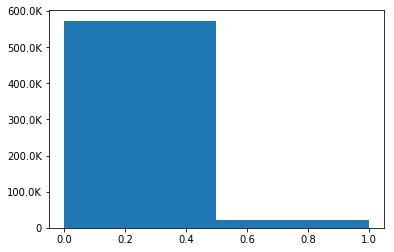

In [8]:
# PLoting the distribution of the labels
fig, ax = plt.subplots()
hist(ax, train.select("target"), bins = 2)

([array([13450.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,  2897.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,  5347.]),
  array([397781.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,  70375.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0., 105362.])],
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

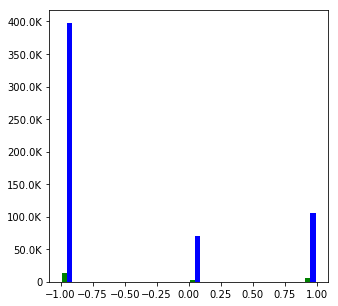

In [9]:
# Ploting ps_car_05_cat
ps_car_12_safe_df = train.filter(col('target') == 0).select(col('ps_car_05_cat').alias('ps_car_12_safe'))
ps_car_12_unsafe_df = train.filter(col('target') == 1).select(col('ps_car_05_cat').alias('ps_car_12_unsafe')) 

fig, axes = plt.subplots()
fig.set_size_inches(5, 5)

hist(axes, [ps_car_12_safe_df, ps_car_12_unsafe_df], bins = 20, color=['green', 'blue'])

([array([0.90350633, 0.        , 0.6931754 , 0.        , 0.        ,
         0.39569315, 0.        , 0.        , 0.24458567, 0.        ,
         0.        , 0.15947189, 0.        , 0.        , 0.29385552,
         0.        , 0.        , 0.08428681, 0.        , 0.08256809]),
  array([0.82076677, 0.        , 0.63770101, 0.        , 0.        ,
         0.40037403, 0.        , 0.        , 0.27617906, 0.        ,
         0.        , 0.1992651 , 0.        , 0.        , 0.32635752,
         0.        , 0.        , 0.10048861, 0.        , 0.09601075])],
 array([0.  , 0.35, 0.7 , 1.05, 1.4 , 1.75, 2.1 , 2.45, 2.8 , 3.15, 3.5 ,
        3.85, 4.2 , 4.55, 4.9 , 5.25, 5.6 , 5.95, 6.3 , 6.65, 7.  ]),
 <a list of 2 Lists of Patches objects>)

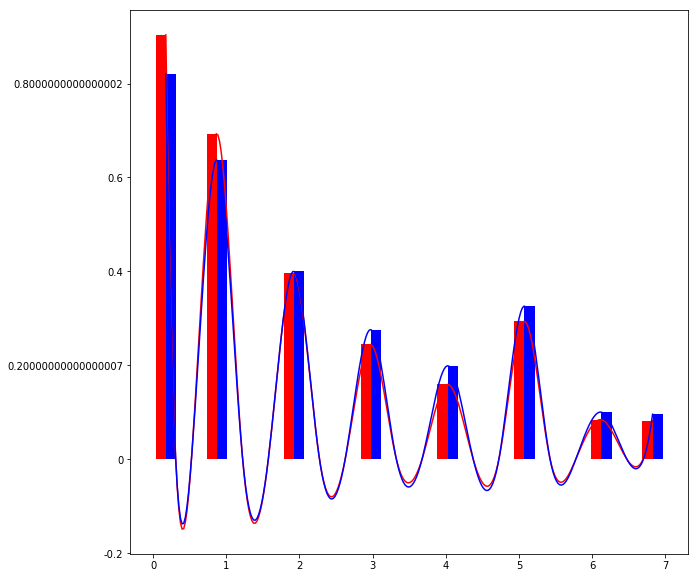

In [10]:
ps_ind_0_safe_df = train.filter(col('target') == 0).select(col('ps_ind_01').alias('ps_ind_0_safe'))
ps_ind_0_unsafe_df = train.filter(col('target') == 1).select(col('ps_ind_01').alias('ps_ind_0_unsafe')) 

fig, axes = plt.subplots()
fig.set_size_inches(10, 10)

distplot(axes, [ps_ind_0_safe_df, ps_ind_0_unsafe_df], bins = 20, color=['red', 'blue'])

In [29]:
# Getting only the relevant columns 
features = train.select([c for c in train.columns if c not in cols_to_del])

In [30]:
# Asemble the data into feature vectors, and calculate the correlation
vecAssembler = VectorAssembler(inputCols=features.columns, outputCol="features")
features_vec = vecAssembler.transform(features)

corr_mat = Correlation.corr(features_vec, "features").head()[0]
corr_array = corr_mat.toArray()

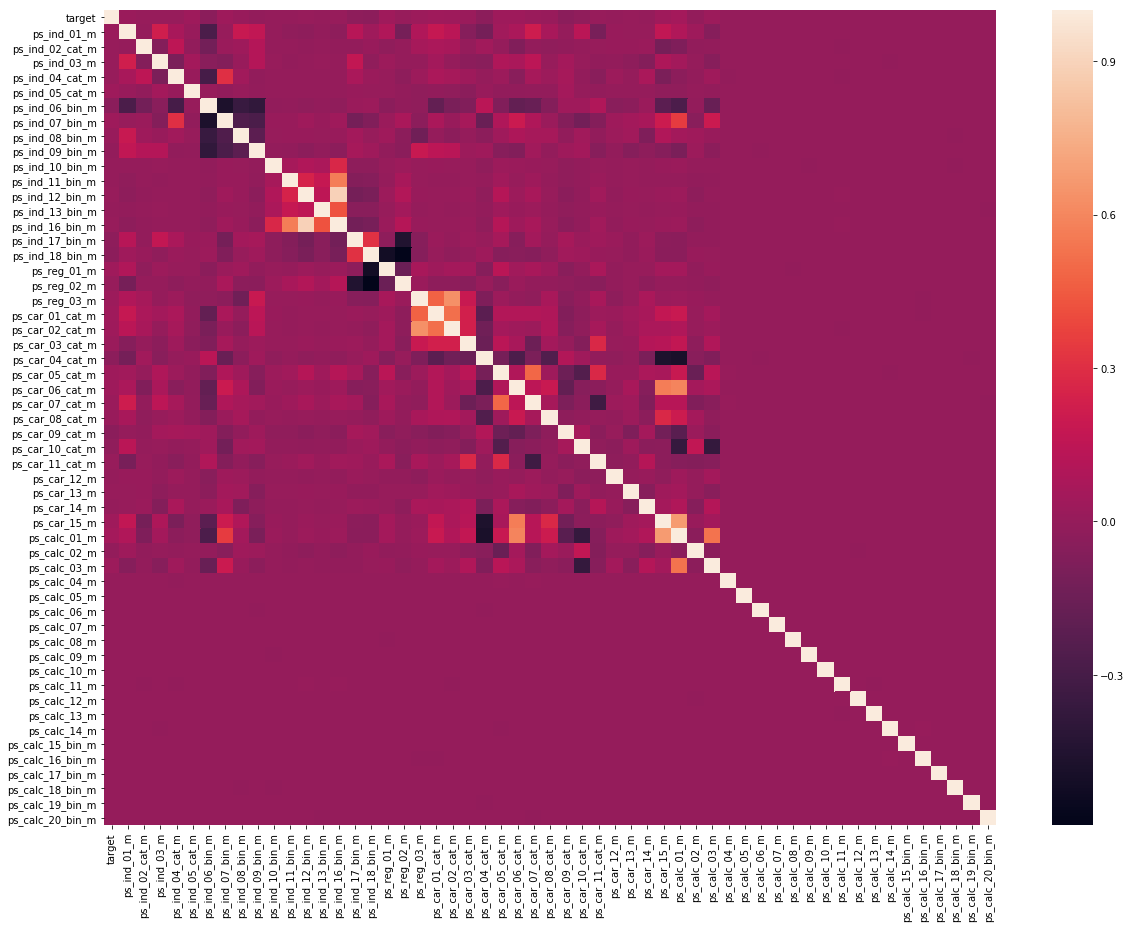

In [31]:
# Ploting the corr matrix
feat_df = pd.DataFrame(data=corr_array, columns=features.columns)
feat_df.index = features.columns

plt.figure(figsize = (20,15))
sns.heatmap(feat_df)

In [60]:
# Creating the classification pipeline
lr = LogisticRegression(maxIter=20)
pipeline = Pipeline(stages=[lr])

In [61]:
# Creating the feature vector that should have only two columns: label and features
features_vec = features_vec.withColumnRenamed("target", "label")
features_data = features_vec.select("label", "features")

In [62]:
# The set of parameters from where our classifier will choose the best one
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

In [63]:
# Random split 90% train, 10% test data
feat_train, feat_test = features_data.randomSplit([0.9, 0.1], seed=12345)

In [64]:
# Running stratified cross validation to choose the best set of parameters 
cross_val = StratifiedCrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  

model = cross_val.fit(feat_train)

In [65]:
results = model.transform(feat_test)

In [66]:
# Compute area under ROC score
predictionLabels = results.select("prediction", "label")
metrics = BinaryClassificationMetrics(predictionLabels.rdd)
metrics.areaUnderROC

0.9791004089050432